# Getting Started with GEDI L2B Version 2 Data in Python
### This tutorial demonstrates how to work with the Canopy Cover and Vertical Profile Metrics ([GEDI02_B.002](https://doi.org/10.5067/GEDI/GEDI02_B.002)) data product.
The Global Ecosystem Dynamics Investigation ([GEDI](https://lpdaac.usgs.gov/data/get-started-data/collection-overview/missions/gedi-overview/)) mission aims to characterize ecosystem structure and dynamics to enable radically improved quantification and understanding of the Earth's carbon cycle and biodiversity. The GEDI instrument produces high resolution laser ranging observations of the 3-dimensional structure of the Earth. GEDI is attached to the International Space Station and collects data globally between 51.6 N and 51.6 S latitudes at the highest resolution and densest sampling of any light detection and ranging (lidar) instrument in orbit to date. The Land Processes Distributed Active Archive Center (LP DAAC) distributes the GEDI Level 1 and Level 2 Version 1 and Version 2 products. The L1B and L2 GEDI products are archived and distributed in the HDF-EOS5 file format. 

---
## Use Case Example:  
This tutorial was developed using an example use case for a project being completed by the National Park Service. **The goal of the project is to use GEDI L2B Version 2 data to observe tree canopy height, cover, and profile over Redwood National Park in northern California.** 

This tutorial will show how to use Python to open GEDI L2B Version 2 files, visualize the sub-orbit of GEDI points (shots), subset to a region of interest, visualize GEDI canopy height and vertical profile metrics, and export subsets of GEDI science dataset (SDS) layers as GeoJSON files that can be loaded into GIS and/or Remote Sensing software programs. 

- [Redwood National Park GeoJSON](https://github.com/nasa/GEDI-Data-Resources/Additional_files/RedwoodNP.geojson)  
    - Contains the administrative boundary for Redwood National Park, available from: [Administrative Boundaries of National Park System Units 12/31/2017 - National Geospatial Data Asset (NGDA) NPS National Parks Dataset](https://irma.nps.gov/DataStore/DownloadFile/594958)

***    
### Data Used in the Example:  
- **GEDI L2B Canopy Cover and Vertical Profile Metrics Data Global Footprint Level - [GEDI02_B.002](https://doi.org/10.5067/GEDI/GEDI02_B.002)**  
     - _The purpose of the L2B dataset is to extract biophysical metrics from each GEDI waveform. These metrics are based on the directional gap probability profile derived from the L1B waveform and include canopy cover, Plant Area Index (PAI), Plant Area Volume Density (PAVD) and Foliage Height Diversity (FHD)._   
     - **Science Dataset (SDS) layers:**
        - /geolocation/digital_elevation_model
        - /geolocation/elev_lowestmode  
        - /geolocation/elev_highestreturn  
        - /geolocation/lat_lowestmode  
        - /geolocation/lon_lowestmode  
        - /rh100  
        - /l2b_quality_flag  
        - /degrade_flag  
        - /sensitivity  
        - /pai  
        - /pavd_z  
        - /geolocation/shot_number  
        - /dz  
        - /selected_l2a_algorithm
***  
# Topics Covered:
1. [**Get Started**](#getstarted)  
    1.1 Import Packages    
    1.2 Set Up the Working Environment and Retrieve Files      
2. [**Import and Interpret Data**](#importinterpret)      
    2.1 Open a GEDI HDF5 File and Read File Metadata     
    2.2 Read SDS Metadata and Subset by Beam   
3. [**Visualize a GEDI Sub-Orbit**](#visualizeorbit)      
    3.1 Subset by Layer and Create a Geodataframe   
    3.2 Visualize a Geodataframe
4. [**Work with GEDI L2B Data**](#L2B)        
    4.1 Import and Extract PAVD   
    4.2 Visualize PAVD    
5. [**Work with GEDI L2B Beam Transects**](#beamtransects)        
    5.1 Quality Filtering        
    5.2 Plot Beam Transects  
    5.3 Subset Beam Transects  
6. [**Plot Profile Transects**](#plottransects)      
    6.1 Plot PAVD Transects  
7. [**Spatial Visualization**](#spatialvisualization)      
    7.1 Import, Subset, and Quality Filter all Beams  
    7.2 Spatial Subsetting  
    7.3 Visualize All Beams: Canopy Height, Elevation, and PAI  
8. [**Export Subsets as GeoJSON Files**](#exportgeojson)     
       
***
# Before Starting this Tutorial:

This tutorial requires a compatible Python Environment and GEDI L2B granule from June 19, 2019 (orbit 02932, sub-orbit `02`) to download. To setup the Python environment and download the file, follow the steps in sections 1 and 2 of the [set-up instruction](https://github.com/nasa/GEDI-Data-Resources/Setup/setup_instructions.md).  

## Source Code used to Generate this Tutorial:
The repository containing all of the required files is located at: https://github.com/nasa/GEDI-Data-Resources      
  
<div class="alert alert-block alert-warning" >
<b>NOTE:</b> This tutorial was developed for GEDI L2B Version 2 HDF-EOS5 files and should only be used for that product. </div>   


---
# 1. Get Started <a id="getstarted"></a>

## 1.1 Import Packages <a id="1.1"></a>
#### Import the required packages and set the input/working directory to run this Jupyter Notebook locally.

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import geopandas as gp
from shapely.geometry import Point
import geoviews as gv
from geoviews import opts, tile_sources as gvts
import holoviews as hv
gv.extension('bokeh', 'matplotlib')
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

## 1.2 Set Up the Working Environment and Retrieve Files<a id="1.2"></a>
#### The input directory is defined as the current working directory. Note that you will need to have the Jupyter Notebook and example data (.h5 and .geojson) stored in this directory in order to execute the tutorial successfully.

In [ ]:
inDir = os.getcwd().split("python")[0]   # Set input directory to the current working directory
os.chdir(inDir)

#### In this section, a GEDI .h5 file has been downloaded to the `inDir` defined above. You will need to download the file directly from the LP DAAC Data Pool in order to execute this tutorial.
### Direct Link to file:  
 - https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_B.002/2019.06.19/GEDI02_B_2019170155833_O02932_02_T02267_02_003_01_V002.h5    

#### Make sure to download the files into the `inDir` directory defined above.

In [ ]:
gediFiles = [g for g in os.listdir(inDir+'\\data') if g.startswith('GEDI02_B') and g.endswith('.h5')]  # List all GEDI L2B .h5 files in inDir
gediFiles

---
# 2. Import and Interpret Data <a id="importinterpret"></a>

## 2.1 Open a GEDI HDF5 File and Read File Metadata <a id="2.1"></a>
#### Read the file using `h5py`. 

In [ ]:
L2B = f'data\\{gediFiles[0]}'
L2B

#### The standard format  for GEDI Version 2 filenames is as follows:
> **GEDI02_B**: Product Short Name    
**2019170155833**: Julian Date and Time of Acquisition (YYYYDDDHHMMSS)  
**O02932**: Orbit Number   
**02**: Sub-Orbit Granule Number (1-4)  
**T02267**: Track Number (Reference Ground Track)   
**02**: Positioning and Pointing Determination System (PPDS) type (00 is predict, 01 rapid, 02 and higher is final)  
**003**: PGE Version Number    
**01**: Granule Production Version  
**V002**: Product Version  

#### Read in a GEDI HDF5 file using the `h5py` package.

In [ ]:
gediL2B = h5py.File(L2B, 'r')  # Read file using h5py

#### Navigate the HDF5 file below. 

In [ ]:
list(gediL2B.keys())

#### The GEDI HDF5 file contains groups in which data and metadata are stored.
#### First, the `METADATA` group contains the file-level metadata.

In [ ]:
list(gediL2B['METADATA'])

This contains useful information such as the creation date, PGEVersion, and VersionID. Below, print the file-level metadata attributes.

In [ ]:
for g in gediL2B['METADATA']['DatasetIdentification'].attrs:
    print(g) 

In [ ]:
print(gediL2B['METADATA']['DatasetIdentification'].attrs['purpose'])

## 2.2 Read SDS Metadata and Subset by Beam <a id="2.2"></a>

####  The GEDI instrument consists of 3 lasers producing a total of 8 beam ground transects. The eight remaining groups contain data for each of the eight GEDI beam transects. For additional information, be sure to check out: https://gedi.umd.edu/instrument/specifications/.

In [ ]:
beamNames = [g for g in gediL2B.keys() if g.startswith('BEAM')]
beamNames

#### One useful piece of metadata to retrieve from each beam transect is whether it is a full power beam or a coverage beam. 

In [ ]:
for g in gediL2B['BEAM0000'].attrs: print(g)

In [ ]:
for b in beamNames: 
    print(f"{b} is a {gediL2B[b].attrs['description']}")

#### Below, pick one of the full power beams that will be used to retrieve GEDI L2B shots in Section 3. 

In [ ]:
beamNames = ['BEAM0110']

#### Identify all the objects in the GEDI HDF5 file below. 
Note: This step may take a while to complete.

In [ ]:
gediL2B_objs = []
gediL2B.visit(gediL2B_objs.append)                                           # Retrieve list of datasets
gediSDS = [o for o in gediL2B_objs if isinstance(gediL2B[o], h5py.Dataset)]  # Search for relevant SDS inside data file
[i for i in gediSDS if beamNames[0] in i][:10]                               # Print the first 10 datasets for selected beam

---
# 3. Visualize a GEDI Orbit <a id="visualizeorbit"></a>
#### In the section below, import GEDI L2B SDS layers into a `GeoPandas` GeoDataFrame for the beam specified above. 
#### Use the `lat_lowestmode` and `lon_lowestmode` to create a `shapely` point for each GEDI shot location. 

## 3.1 Subset by Layer and Create a Geodataframe <a id="3.1"></a>

#### Read in the SDS and take a representative sample (every 100th shot) and append to lists, then use the lists to generate a `pandas` dataframe.

In [ ]:
lonSample, latSample, shotSample, qualitySample, beamSample = [], [], [], [], []  # Set up lists to store data

# Open the SDS
lats = gediL2B[f'{beamNames[0]}/geolocation/lat_lowestmode'][()]
lons = gediL2B[f'{beamNames[0]}/geolocation/lon_lowestmode'][()]
shots = gediL2B[f'{beamNames[0]}/geolocation/shot_number'][()]
quality = gediL2B[f'{beamNames[0]}/l2b_quality_flag'][()]

# Take every 100th shot and append to list
for i in range(len(shots)):
    if i % 100 == 0:
        shotSample.append(str(shots[i]))
        lonSample.append(lons[i])
        latSample.append(lats[i])
        qualitySample.append(quality[i])
        beamSample.append(beamNames[0])
            
# Write all of the sample shots to a dataframe
latslons = pd.DataFrame({'Beam': beamSample, 'Shot Number': shotSample, 'Longitude': lonSample, 'Latitude': latSample,
                         'Quality Flag': qualitySample})
latslons

#### Above is a dataframe containing columns describing the beam, shot number, lat/lon location, and quality information about each shot.

In [ ]:
# Clean up variables that will no longer be needed
del beamSample, quality, qualitySample, gediL2B_objs, latSample, lats, lonSample, lons, shotSample, shots 

#### Below, create an additional column called 'geometry' that contains a `shapely` point generated from each lat/lon location from the shot. 

In [ ]:
# Take the lat/lon dataframe and convert each lat/lon to a shapely point
latslons['geometry'] = latslons.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

#### Next, convert to a `Geopandas` GeoDataFrame.

In [ ]:
# Convert to a Geodataframe
latslons = gp.GeoDataFrame(latslons)
latslons = latslons.drop(columns=['Latitude','Longitude'])
latslons['geometry']

#### Pull out and plot an example `shapely` point below.

In [ ]:
latslons['geometry'][0]

## 3.2 Visualize a GeoDataFrame <a id="3.2"></a>
#### In this section, use the GeoDataFrame and the `geoviews` python package to spatially visualize the location of the GEDI shots on a basemap and import a GeoJSON file of the spatial region of interest for the use case example: Redwood National Park.

In [ ]:
# Define a function for visualizing GEDI points
def pointVisual(features, vdims):
    return (gvts.EsriImagery * gv.Points(features, vdims=vdims).options(tools=['hover'], height=500, width=900, size=5, 
                                                                        color='yellow', fontsize={'xticks': 10, 'yticks': 10, 
                                                                                                  'xlabel':16, 'ylabel': 16}))

#### Import a GeoJSON of Redwood National Park as an additional GeoDataFrame. Note that you will need to have downloaded the [GeoJSON](https://git.earthdata.nasa.gov/projects/LPDUR/repos/gedi-v2-tutorials/browse/RedwoodNP.geojson) from the bitbucket repo containing this tutorial and have it saved in the same directory as this Jupyter Notebook.

In [ ]:
redwoodNP = gp.GeoDataFrame.from_file('Data\\RedwoodNP.geojson')  # Import GeoJSON as GeoDataFrame

In [ ]:
redwoodNP

In [ ]:
redwoodNP['geometry'][0]  # Plot GeoDataFrame

#### Defining the vdims below will allow you to hover over specific shots and view information about them.

In [ ]:
# Create a list of geodataframe columns to be included as attributes in the output map
vdims = []
for f in latslons:
    if f not in ['geometry']:
        vdims.append(f)
vdims

#### Below, combine a plot of the Redwood National Park Boundary (combine two `geoviews` plots using `*`) with the point visual mapping function defined above in order to plot (1) the representative GEDI shots, (2) the region of interest, and (3) a basemap layer. 

In [ ]:
# Call the function for plotting the GEDI points
gv.Polygons(redwoodNP['geometry']).opts(line_color='red', color=None) * pointVisual(latslons, vdims = vdims)

#### Above is a good illustration of the new GEDI _Version 2_ sub-orbit granules (remember that GEDI _Version 1_  files are stored as one ISS orbit). One of the benefits of using geoviews is the interactive nature of the output plots. Use the tools to the right of the map above to zoom in and find the shots intersecting Redwood National Park. 
> (**HINT**: find where the orbit intersects the west coast of the United States)

#### Below is a screenshot of the region of interest:

![GEDI_L2B_V2_Tutorial_1.png](../../img/GEDI_L2B_V2_Tutorial_1.png "Sample of GEDI L1B shots in yellow (orbit 2932) plotted over Redwood National Park, USA.")
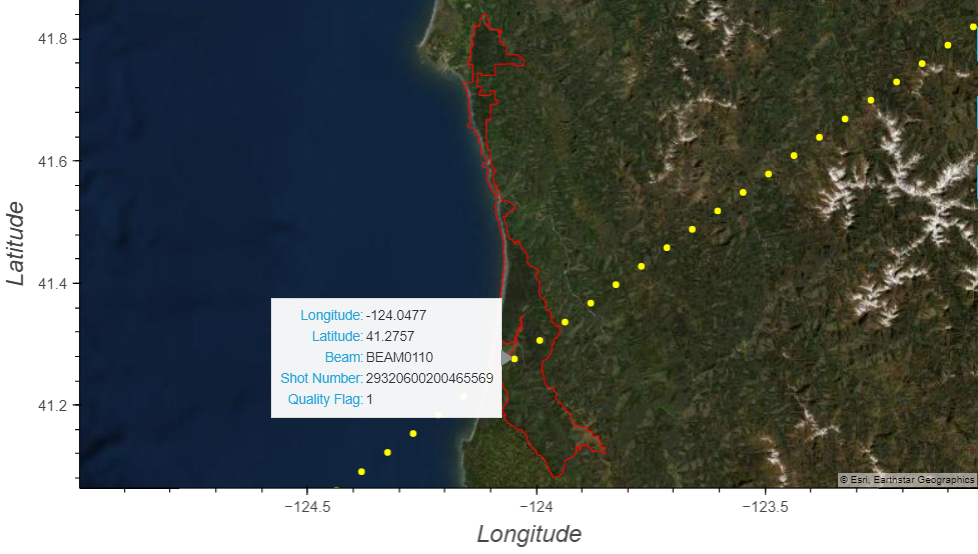

#### Side Note: Wondering what the 0's and 1's for `l2b_quality_flag` mean?

In [ ]:
print(f"Quality Flag: {gediL2B[b]['l2b_quality_flag'].attrs['description']}")

#### Above, 0 is poor quality and a quality_flag value of 1 indicates the laser shot meets criteria based on energy, sensitivity, amplitude, and real-time surface tracking quality. We will show an example of how to quality filter GEDI data in section 5.1.
#### After finding one of the shots within Redwood NP, find the index for that shot number so that we can find the correct shot to visualize in Section 4. 

#### Each GEDI shot has a unique shot identifier (shot number) that is available within each data group of the product. The shot number is important to retain in any data subsetting as it will allow the user to link any shot record back to the original orbit data, and to link any shot and its data between the L1 and L2 products. The standard format  for GEDI Shots is as follows:

### Shot: 29320600200465601
> **2932**: Orbit Number      
**06**: Beam Number    
**0**: Reserved for future use     
**02**: Sub-orbit Granule Number    
**004**: Minor frame number   
**65601**: Shot index  

In [ ]:
del latslons  # No longer need the geodataframe used to visualize the full GEDI orbit

---
# 4. Work with GEDI L2B Data <a id="L2B"></a>
#### The L2B product contains biophysical information derived from the geolocated GEDI return waveforms including total and vertical profiles of canopy cover and Plant Area Index (PAI), the vertical Plant Area Volume Density (PAVD) profile, and Foliage Height Diversity (FHD).
Detailed product information can be found on the [GEDI L2B Product Page](https://doi.org/10.5067/GEDI/GEDI02_B.002).

## 4.1 Import and Extract Specific Shots
#### Notice that there are over a thousand datasets available in the GEDI L2B product. In the code blocks below, you will subset to just a few of the datasets available.
#### In this section, learn how to extract and subset specific shots and plot Plant Area Volume Density (PAVD) using `holoviews`. 

In [ ]:
len(gediSDS)

In [ ]:
beamNames

In [ ]:
beamSDS = [g for g in gediSDS if beamNames[0] in g]  # Subset to a single beam
len(beamSDS)

### We will set the shot index used as an example from the [GEDI L1B Tutorial](https://git.earthdata.nasa.gov/projects/LPDUR/repos/gedi-v2-tutorials/browse/GEDI_L1B_V2_Tutorial.ipynb) and [GEDI L2A Tutorial](https://git.earthdata.nasa.gov/projects/LPDUR/repos/gedi-v2-tutorials/browse/GEDI_L2A_V2_Tutorial.ipynb) to show how to subset a single shot of GEDI L2B data.

In [ ]:
shot = 29320600200465599

In [ ]:
index = np.where(gediL2B[f'{beamNames[0]}/shot_number'][()]==shot)[0][0]  # Set the index for the shot identified above
index

## 4.2 Visualize PAVD
#### In section 4.2, import the PAVD metrics (`pavd_z`) and begin exploring how to plot them.

In [ ]:
pavd = gediL2B[[g for g in beamSDS if g.endswith('/pavd_z')][0]]  # PAVD

#### Print the description for the PAVD dataset.

In [ ]:
print(f"Plant Area Volume Density is {pavd.attrs['description']}")

#### Below, open the `dz` layer in order to define the correct vertical step size.

In [ ]:
# Grab vertical step size 
dz = gediL2B[f'{beamNames[0]}/ancillary/dz'][0]
dz

#### So the vertical step size is 5.0 meters.

In [ ]:
print(f"The shape of PAVD is {pavd.shape}.")

#### And it looks like PAVD includes 30 "steps" in each shot, describing the PAVD at height = step # * `dz`.
#### Now, bring in other useful L2B datasets such as `elev_lowestmode`, `lat_lowestmode` and `lon_lowestmode`.

In [ ]:
# Bring in the desired SDS
elev = gediL2B[f'{beamNames[0]}/geolocation/elev_lowestmode'][()]  # Latitude
lats = gediL2B[f'{beamNames[0]}/geolocation/lat_lowestmode'][()]  # Latitude
lons = gediL2B[f'{beamNames[0]}/geolocation/lon_lowestmode'][()]  # Longitude

#### Grab the location, elevation, and PAVD metrics for the shot defined above:

In [ ]:
shotElev = elev[index]
shotLat = lats[index]
shotLon = lons[index]
shotPAVD = pavd[index]

#### Put everything together to identify the shot that we want to extract:

In [ ]:
print(f"The shot is located at: {str(shotLat)}, {str(shotLon)} (shot ID: {shot}, index {index}) and is from {beamNames[0]}.")

#### Next, reformat PAVD into a list of tuples containing each PAVD value and height.

In [ ]:
pavdAll = []
pavdElev = []

for i, e in enumerate(range(len(shotPAVD))):
    if shotPAVD[i] > 0:
        pavdElev.append((shot, shotElev + dz * i, shotPAVD[i]))  # Append tuple of shot number, elevation, and PAVD
pavdAll.append(pavdElev)                                         # Append to final list

#### Below, plot each shot by using `holoviews` Path() function, with the PAVD plotted in the third dimension in shades of green.

In [ ]:
path1 = hv.Path(pavdAll, vdims='PAVD').options(color='PAVD', clim=(0,0.1), cmap='Greens', line_width=20, colorbar=True, 
                                               width=700, height=550, clabel='PAVD', xlabel='Shot Number', 
                                               ylabel='Elevation (m)', fontsize={'title':16, 'xlabel':16, 'ylabel': 16,
                                                                                 'xticks':12, 'yticks':12, 
                                                                                 'clabel':12, 'cticks':10})
path1

### Congratulations! You have plotted your first PAVD profile.

---
# 5. Work with GEDI L2B Beam Transects<a id="beamtransects"></a>
#### Next, import a number of desired SDS layers for BEAM0110 (for the entire orbit) and create a `pandas` Dataframe to store the arrays.

In [ ]:
# Open all of the desired SDS
dem = gediL2B[[g for g in beamSDS if g.endswith('/digital_elevation_model')][0]][()]
zElevation = gediL2B[[g for g in beamSDS if g.endswith('/elev_lowestmode')][0]][()]
zHigh = gediL2B[[g for g in beamSDS if g.endswith('/elev_highestreturn')][0]][()]
zLat = gediL2B[[g for g in beamSDS if g.endswith('/lat_lowestmode')][0]][()]
zLon = gediL2B[[g for g in beamSDS if g.endswith('/lon_lowestmode')][0]][()]
canopyHeight = gediL2B[[g for g in beamSDS if g.endswith('/rh100')][0]][()]
quality = gediL2B[[g for g in beamSDS if g.endswith('/l2b_quality_flag')][0]][()]
degrade = gediL2B[[g for g in beamSDS if g.endswith('/degrade_flag')][0]][()]
sensitivity = gediL2B[[g for g in beamSDS if g.endswith('/sensitivity')][0]][()]
pavd = gediL2B[f'{beamNames[0]}/pavd_z'][()]
shotNums = gediL2B[f'{beamNames[0]}/shot_number'][()]
selectedAlgorithmL2A = gediL2B[[g for g in beamSDS if g.endswith('/selected_l2a_algorithm')][0]][()]

# Create a shot index
shotIndex = np.arange(shotNums.size)

#### In the GEDI L2B product, Canopy Height is stored in units (cm), so below convert to meters.

In [ ]:
canopyHeight = canopyHeight / 100  # Convert RH100 from cm to m 

#### As mentioned in the sections above, Plant Area Volume Density (pavd) is defined as the _Vertical Plant Area Volume Density profile with a vertical step size of dZ_. Below, reformat the shape of the PAVD layer in order to add it to the dataframe below.

In [ ]:
print(f"The shape of Canopy Height is {canopyHeight.shape} vs. the shape of PAVD, which is {pavd.shape}.")

#### Above, notice that unlike a SDS layer like Canopy Height, which has a single value for each shot, PAVD has 30 values (representing different vertical heights) for each shot.
#### Below, reformat the data into a list of values for each shot. 

In [ ]:
# Set up an empty list to append to 
pavdA = []
for i in range(len(pavd)):
    
    # If any of the values are fill value, set to nan
    pavdF = [np.nan]
    for p in range(len(pavd[i])):
        if pavd[i][p]!= -9999:
            pavdF.append(pavd[i][p])  # If the value is not fill value, append to list
    pavdA.append(pavdF)               # Append back to master list

#### Note: The cell above may take up to a minute to process.

#### Below, notice the reformatted PAVD layer, which should now fit into the dataframe created below.

In [ ]:
len(pavdA)

In [ ]:
# Take the DEM, GEDI-produced Elevation, and Canopy height and add to a Pandas dataframe
transectDF = pd.DataFrame({
    'Shot Index': shotIndex,
    'Shot Number': shotNums,
    'Latitude': zLat,
    'Longitude': zLon,
    'Tandem-X DEM': dem,
    'Elevation (m)': zElevation,
    'Canopy Elevation (m)': zHigh,
    'Canopy Height (rh100)': canopyHeight,
    'Quality Flag': quality,
    'Degrade Flag': degrade, 
    'Plant Area Volume Density': pavdA,
    'Sensitivity': sensitivity,
    'Selected L2A Algorithm': selectedAlgorithmL2A
    })

In [ ]:
transectDF

#### Notice the unusual values listed above--those shots are flagged as poor quality and will be removed in Section 5.1.
#### Now that you have the desired SDS into a `pandas` dataframe, begin plotting the entire beam transect:

In [ ]:
# Plot Canopy Height
canopyVis = hv.Scatter((transectDF['Shot Index'], transectDF['Canopy Height (rh100)']))
canopyVis.opts(color='darkgreen', height=500, width=900, title=f'GEDI L2B Full Transect {beamNames[0]}',
               fontsize={'title':16, 'xlabel':16, 'ylabel': 16}, size=0.1, xlabel='Shot Index', ylabel='Canopy Height (m)')

#### Congratulations! You have plotted your first GEDI sub-orbit beam transect. Notice above that things look a little messy--before we dive deeper into plotting full transects, let's quality filter the shots in the section below.

In [ ]:
del canopyVis, canopyHeight, degrade, dem, pavd, pavdA, quality, sensitivity, shotIndex, shotNums, zElevation, zHigh, zLat, zLon, selectedAlgorithmL2A

## 5.1 Quality Filtering
#### Now that you have the desired layers imported as a dataframe for the entire beam transect, let's perform quality filtering.
#### Below, remove any shots where the `l2b_quality_flag` is set to 0 by defining those shots as `nan`. 
#### The syntax of the line below can be read as: in the dataframe, find the rows "where" the quality flag is not equal (ne) to 0. If a row (shot) does not meet the condition, set all values equal to `nan` for that row.

In [ ]:
transectDF = transectDF.where(transectDF['Quality Flag'].ne(0))  # Set any poor quality returns to NaN

In [ ]:
transectDF

#### Below, quality filter even further by using the `degrade_flag` (Greater than zero if the shot occurs during a degrade period, zero otherwise) and the `Sensitivity` layer, using a threshold of 0.95.

In [ ]:
transectDF = transectDF.where(transectDF['Degrade Flag'] < 1)
transectDF = transectDF.where(transectDF['Sensitivity'] > 0.95)

#### Below, drop all of the shots that did not pass the quality filtering standards outlined above from the `transectDF`.

In [ ]:
transectDF = transectDF.dropna()  # Drop all of the rows (shots) that did not pass the quality filtering above

In [ ]:
print(f"Quality filtering complete, {len(transectDF)} high quality shots remaining.")

## 5.2 Plot Beam Transects
#### Next, plot the full remaining transect of high quality values using `holoviews` Scatter(). Combine the Tandem-X derived elevation, the GEDI-derived elevation, and the Canopy Top Elevation in a combined holoviews plot.

In [ ]:
# Plot Digital Elevation Model
demVis = hv.Scatter((transectDF['Shot Index'], transectDF['Tandem-X DEM']), label='Tandem-X DEM')
demVis = demVis.opts(color='black', height=500, width=900, fontsize={'xlabel':16, 'ylabel': 16}, size=1.5)

In [ ]:
# Plot GEDI-Retrieved Elevation
zVis = hv.Scatter((transectDF['Shot Index'], transectDF['Elevation (m)']), label='GEDI-derived Elevation')
zVis = zVis.opts(color='saddlebrown', height=500, width=900, fontsize={'xlabel':16, 'ylabel': 16}, size=1.5)

In [ ]:
# Plot Canopy Top Elevation
rhVis = hv.Scatter((transectDF['Shot Index'], transectDF['Canopy Elevation (m)']), label='Canopy Top Elevation')
rhVis = rhVis.opts(color='darkgreen', height=500, width=900, fontsize={'xlabel':16, 'ylabel': 16}, size=1.5, 
                   tools=['hover'], xlabel='Shot Index', ylabel='Elevation (m)')

In [ ]:
# Combine all three scatterplots
(demVis * zVis * rhVis).opts(show_legend=True, legend_position='top_left',fontsize={'title':14, 'xlabel':16, 'ylabel': 16}, 
                             title=f'{beamNames[0]} Full Transect: {L2B.split(".")[0]}')

#### The plot still looks a bit messy this far zoomed out--feel free to pan, zoom, and explore different areas of the plot. The waveforms plotted in section 4 were 46597-46600. If you zoom into the high-quality shots between 4.000e+5 and 5.000e+5, you will find the portion of the transect intersecting Redwood National Park, seen below:
![GEDI_L2B_V2_Tutorial_2.png](../../img/GEDI_L2B_V2_Tutorial_2.png "BEAM0110 Transect Plot of Tandem-X Elevation, GEDI-derived Elevation, and Canopy Top Elevation over Redwood National Park, USA.")
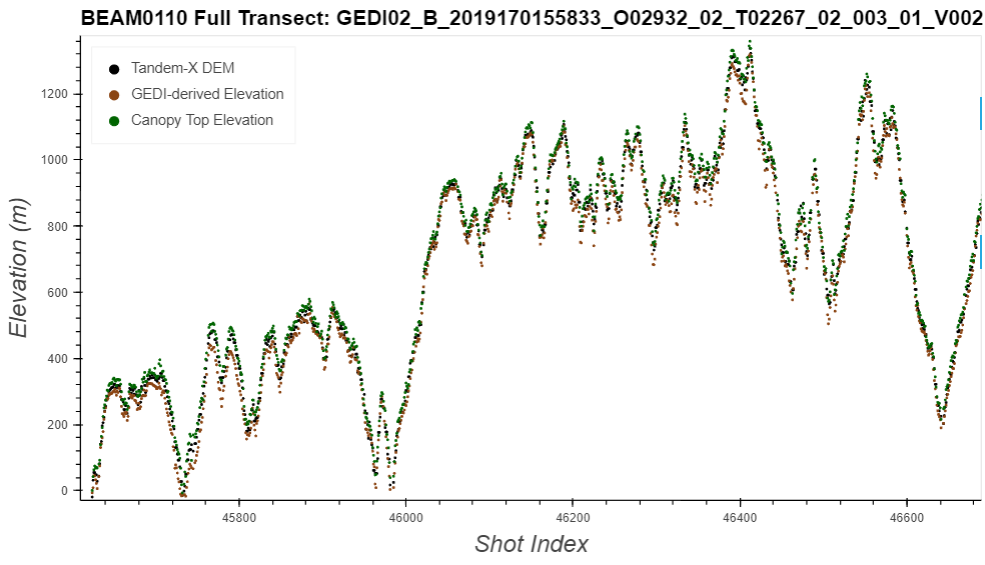

## 5.3 Subset Beam Transects

#### Now, subset down to a smaller transect centered on the shot analyzed in the sections above.

In [ ]:
print(index)

In [ ]:
# Grab 50 points before and after the shot visualized above
start = index - 50
end = index + 50 

In [ ]:
print(f"The transect begins at ({transectDF['Latitude'][start]}, {transectDF['Longitude'][start]}) and ends at ({transectDF['Latitude'][end]}, {transectDF['Longitude'][end]}).")

#### Below, subset the transect using `.loc`.

In [ ]:
transectDF = transectDF.loc[start:end]  # Subset the Dataframe to only the selected region of interest over Redwood NP

---
# 6. Plot Profile Transects <a id="plottransects"></a>
#### In this section, plot the transect subset using elevation, canopy height, and plant area volume density (PAVD) metrics.

#### In order to get an idea of the length of the beam transect that you are plotting, you can plot the x-axis as distance, which is calculated below.

In [ ]:
# Calculate along-track distance
distance = np.arange(0.0, len(transectDF.index) * 60, 60)  # GEDI Shots are spaced 60 m apart
transectDF['Distance'] = distance                          # Add Distance as a new column in the dataframe

## 6.1 Plot PAVD Transects

#### Similar to what was done with PAVD in the sections above, reformat PAVD into a list of tuples containing each PAVD value and height by shot.

In [ ]:
pavdAll = []
for j, s in enumerate(transectDF.index):
    pavdShot = transectDF['Plant Area Volume Density'][s]
    elevShot = transectDF['Elevation (m)'][s]
    pavdElev = []
    
    # Remove fill values
    if np.isnan(pavdShot).all():
        continue
    else:
        del pavdShot[0]
    for i, e in enumerate(range(len(pavdShot))):
        if pavdShot[i] > 0:
            pavdElev.append((distance[j], elevShot + dz * i, pavdShot[i]))  # Append tuple of distance, elevation, and PAVD
    pavdAll.append(pavdElev)                                                # Append to final list

In [ ]:
canopyElevation = [p[-1][1] for p in pavdAll]  # Grab the canopy elevation by selecting the last value in each PAVD

#### Below, plot each shot by using `holoviews` Path() function, with the PAVD plotted in the third dimension in shades of green.

In [ ]:
path1 = hv.Path(pavdAll, vdims='PAVD').options(color='PAVD', clim=(0,0.3), cmap='Greens', line_width=8, colorbar=True, 
                                               width=950, height=500, clabel='PAVD', xlabel='Distance Along Transect (m)',
                                               ylabel='Elevation (m)', fontsize={'title':16, 'xlabel':16, 'ylabel': 16,
                                                                                 'xticks':12, 'yticks':12, 
                                                                                 'clabel':12, 'cticks':10})
path1

#### Add in the ground elevation and canopy top elevation for better context as to where in the canopy the highest PAVD exists.

In [ ]:
path2 = hv.Curve((distance, transectDF['Elevation (m)']), label='Ground Elevation').options(color='black', line_width=2)
path3 = hv.Curve((distance, canopyElevation), label='Canopy Top Elevation').options(color='grey', line_width=1.5)

In [ ]:
# Plot all three together
path = path1 * path2 * path3
path.opts(height=500,width=980, ylim=(min(transectDF['Elevation (m)']) - 5, max(canopyElevation) + 5),
          xlabel='Distance Along Transect (m)', ylabel='Elevation (m)', legend_position='bottom_right',
          fontsize={'title':15, 'xlabel':15, 'ylabel': 15, 'xticks': 14, 'yticks': 14, 'legend': 14}, 
          title=f'GEDI L2B {beamNames[0]} PAVD over Redwood National Park on June 19, 2019') 

#### Above, you can get an idea about the terrain over the region of interest, particularly the classic "V" representing the river valley that is bisected by the transect. In terms of vegetation structure, this plot does a good job of showing not only which portions of the canopy are taller, but also where they are denser (darker shades of green).

In [ ]:
del distance, canopyElevation, pavdAll, pavdElev, pavdShot, transectDF

### At this point you have visualized the elevation, canopy, and vertical structure of specific footprints over Redwood national park, and for a transect cutting through the national park. In section 7 you will look at mapping all of the high-quality shots from all eight GEDI beams for a given region of interest in order to gain knowledge on the spatial distribution of and characteristics of the canopy over Redwood National Park. 

---
# 7. Spatial Visualization<a id="spatialvisualization"></a>
#### Section 7 combines many of the techniques learned above including how to import GEDI datasets, perform quality filtering, spatial subsetting, and visualization. 

## 7.1 Import, Subset, and Quality Filter All Beams

#### Below, re-open the GEDI L2B observation--but this time, loop through and import data for all 8 of the GEDI beams.

In [ ]:
beamNames = [g for g in gediL2B.keys() if g.startswith('BEAM')]

In [ ]:
beamNames

#### Loop through each of the desired datasets (SDS) for each beam, append to lists, and transform into a `pandas` DataFrame.

In [ ]:
# Set up lists to store data
shotNum, dem, zElevation, zHigh, zLat, zLon, canopyHeight, quality, degrade, sensitivity, pai, beamI, selectedAlgorithmL2A = ([] for i in range(13))

In [ ]:
# Loop through each beam and open the SDS needed
for b in beamNames:
    [shotNum.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()]]
    [dem.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/digital_elevation_model') and b in g][0]][()]]
    [zElevation.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/elev_lowestmode') and b in g][0]][()]]  
    [zHigh.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/elev_highestreturn') and b in g][0]][()]]  
    [zLat.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/lat_lowestmode') and b in g][0]][()]]  
    [zLon.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/lon_lowestmode') and b in g][0]][()]]  
    [canopyHeight.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/rh100') and b in g][0]][()]]  
    [quality.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/l2b_quality_flag') and b in g][0]][()]]  
    [degrade.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/degrade_flag') and b in g][0]][()]]  
    [sensitivity.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/sensitivity') and b in g][0]][()]]  
    [beamI.append(h) for h in [b] * len(gediL2B[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()])]  
    [selectedAlgorithmL2A.append(h) for h in gediL2B[[g for g in gediSDS if g.endswith('/selected_l2a_algorithm') and b in g][0]][()]]  
    [pai.append(h) for h in gediL2B[f'{b}/pai'][()]]    

In [ ]:
# Convert lists to Pandas dataframe
allDF = pd.DataFrame({
    'Shot Number': shotNum,
    'Beam': beamI,
    'Latitude': zLat,
    'Longitude': zLon,
    'Tandem-X DEM': dem,
    'Elevation (m)': zElevation,
    'Canopy Elevation (m)': zHigh,
    'Canopy Height (rh100)': canopyHeight,
    'Quality Flag': quality,
    'Plant Area Index': pai,
    'Degrade Flag': degrade,
    'Sensitivity': sensitivity,
    'Selected L2A Algorithm': selectedAlgorithmL2A
    })

In [ ]:
del beamI, canopyHeight, degrade, dem, gediSDS, pai, quality, sensitivity, zElevation, zHigh, zLat, zLon, shotNum, selectedAlgorithmL2A

## 7.2 Spatial Subsetting
#### Below, subset the pandas dataframe using a simple bounding box region of interest. If you are interested in spatially clipping GEDI shots to a GeoJSON region of interest, be sure to check out the GEDI-Subsetter python script available at: https://git.earthdata.nasa.gov/projects/LPDUR/repos/gedi-subsetter/browse.

In [ ]:
len(allDF)

#### Almost 800,000 shots are contained in this single GEDI sub-orbit granule! Below subset down to only the shots falling within this small bounding box encompassing Redwood National Park. `RedwoodNP` our `geopandas` geodataframe can be called for the "envelope" or smallest bounding box encompassing the entire region of interest. Here, use that as the bounding box for subsetting the GEDI shots.

In [ ]:
redwoodNP.envelope[0].bounds

In [ ]:
minLon, minLat, maxLon, maxLat = redwoodNP.envelope[0].bounds  # Define the min/max lat/lon from the bounds of Redwood NP

#### Filter by the bounding box, which is done similarly to filtering by quality in section 6.1 above.

In [ ]:
allDF = allDF.where(allDF['Latitude'] > minLat)
allDF = allDF.where(allDF['Latitude'] < maxLat)
allDF = allDF.where(allDF['Longitude'] > minLon)
allDF = allDF.where(allDF['Longitude'] < maxLon)

In [ ]:
allDF = allDF.dropna()  # Drop shots outside of the ROI

In [ ]:
len(allDF)

#### Notice you have drastically reduced the number of shots you are working with (which will greatly enhance your experience in plotting them below). But first, remove any poor quality shots that exist within the ROI.

In [ ]:
# Set any poor quality returns to NaN
allDF = allDF.where(allDF['Quality Flag'].ne(0))
allDF = allDF.where(allDF['Degrade Flag'] < 1)
allDF = allDF.where(allDF['Sensitivity'] > 0.95)
allDF = allDF.dropna()
len(allDF)

#### Down to roughly 2000 shots, next create a `Shapely` Point out of each shot and insert it as the geometry column in the [soon to be geo]dataframe.

In [ ]:
# Take the lat/lon dataframe and convert each lat/lon to a shapely point
allDF['geometry'] = allDF.apply(lambda row: Point(row.Longitude, row.Latitude), axis=1)

In [ ]:
# Convert to geodataframe
allDF = gp.GeoDataFrame(allDF)
allDF = allDF.drop(columns=['Latitude','Longitude'])

## 7.3 Visualize All Beams: Canopy Height, Elevation, and PAI

#### Now, using the `pointVisual` function defined in section 3.2, plot the `geopandas` GeoDataFrame using `geoviews`.

In [ ]:
allDF['Shot Number'] = allDF['Shot Number'].astype(str)  # Convert shot number to string

vdims = []
for f in allDF:
    if f not in ['geometry']:
        vdims.append(f)

visual = pointVisual(allDF, vdims = vdims)
visual * gv.Polygons(redwoodNP['geometry']).opts(line_color='red', color=None)

#### Feel free to pan and zoom in to the GEDI shots in yellow. 

### Now let's not only plot the points in the geodataframe but also add a colormap for Canopy Height (m), Elevation (m), and Plant Area Index (PAI). 

In [ ]:
allDF['Canopy Height (rh100)'] = allDF['Canopy Height (rh100)'] / 100  # Convert canopy height from cm to m 

In [ ]:
# Plot the basemap and geoviews Points, defining the color as the Canopy Height for each shot
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Canopy Height (rh100)',cmap='plasma', size=3, tools=['hover'],
                                                          clim=(0,102), colorbar=True, clabel='Meters',
                                                          title='GEDI Canopy Height over Redwood National Park: June 19, 2019',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)

#### Above and in the screenshot below, notice the higher canopy heights (shades of yellow) over the Redwood stands of the national park vs. other types of forests (pink-blue) vs. the low-lying (and consequently flat) profiles over lakes and rivers (purple).
![GEDI_L2B_V2_Tutorial_3.png](../../img/GEDI_L2B_V2_Tutorial_3.png "GEDI Canopy Height over Redwood National Park: June 19, 2019.")
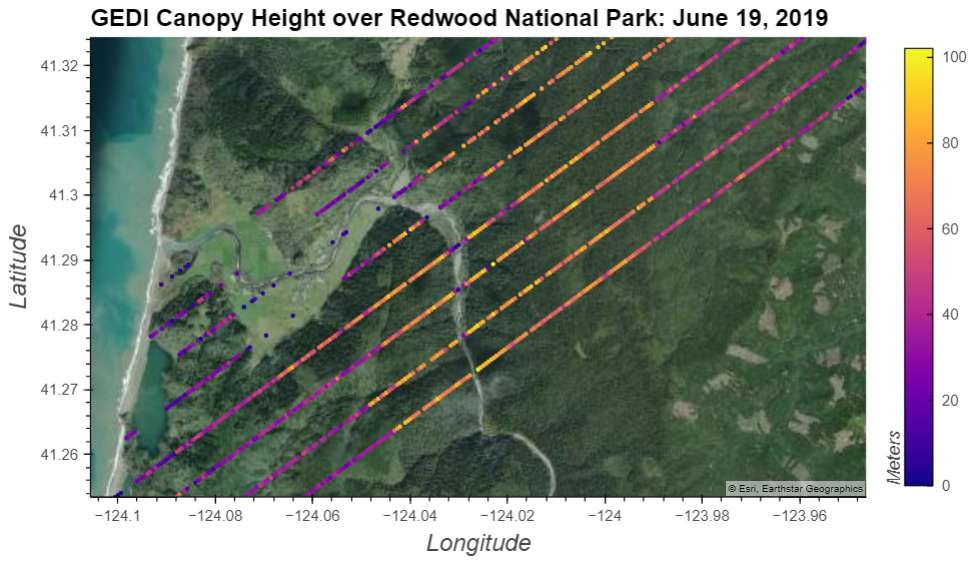

#### Next, take a look at the GEDI-derived elevation over the shots. Notice below that the colormap is changed to 'terrain'. 

In [ ]:
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Elevation (m)',cmap='terrain', size=3, tools=['hover'],
                                                          clim=(min(allDF['Elevation (m)']), max(allDF['Elevation (m)'])),
                                                          colorbar=True, clabel='Meters',
                                                          title='GEDI Elevation over Redwood National Park: June 19, 2019',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)

#### Last but certainly not least, `Plant Area Index`:

In [ ]:
(gvts.EsriImagery * gv.Points(allDF, vdims=vdims).options(color='Plant Area Index',cmap='Greens', size=3, tools=['hover'],
                                                          clim=(0,1), colorbar=True, clabel='m2/m2',
                                                          title='GEDI PAI over Redwood National Park: June 19, 2019',
                                                          fontsize={'xticks': 10, 'yticks': 10, 'xlabel':16, 'clabel':12,
                                                                    'cticks':10,'title':16,'ylabel':16})).options(height=500,
                                                                                                                  width=900)

### Success! You have now learned how to start working with GEDI L2B files in Python as well as some interesting strategies for visualizing those data in order to better understand your specific region of interest. Using this Jupyter Notebook as a workflow, you should now be able to switch to GEDI files over your specific region of interest and re-run the notebook. Good Luck!

---
# 8. Export Subsets as GeoJSON Files<a id="exportgeojson"></a>
#### In this section, export the GeoDataFrame as a `.geojson` file that can be easily opened in your favorite remote sensing and/or GIS software and will include an attribute table with all of the shots/values for each of the SDS layers in the dataframe.

In [ ]:
gediL2B.filename  # L2B Filename

In [ ]:
outName = gediL2B.filename.replace('.h5', '.json')  # Create an output file name using the input file name
outName

In [ ]:
allDF.to_file(outName, driver='GeoJSON')  # Export to GeoJSON

In [ ]:
del allDF 

<div class="alert alert-block alert-info">
    <h1> Contact Information </h1>
    <h3> Material written by LP DAAC<sup>1</sup> </h3>
    <ul>
        <b>Contact:</b> LPDAAC@usgs.gov <br> 
        <b>Voice:</b> +1-605-594-6116 <br>
        <b>Organization:</b> Land Processes Distributed Active Archive Center (LP DAAC) <br>
        <b>Website:</b> https://lpdaac.usgs.gov/ <br>
        <b>Date last modified:</b> 03-27-2023 <br>
    </ul>
    
<sup>1</sup>KBR Inc., contractor to the U.S. Geological Survey, Earth Resources Observation and Science (EROS) Center, Sioux Falls, South Dakota, 57198-001, USA. Work performed under USGS contract G15PD00467 for LP DAAC<sup>2</sup>.

<sup>2</sup>LP DAAC Work performed under NASA contract NNG14HH33I.
</div>